# Проект 6. Рекомендательные системы.

# Часть 1: обработка данных и EDA

**Задачи**:
1. Изучить тренировочный и тестовый датасеты
2. Провести визуальный и статистический анализ датасетов
3. Очистить данные от дубликатов, заполнить пропуски и т.п.
4. Сгенерировать новые признаки
3. Визуализировать данные и установить закономерности
4. Дать комментарии и сделать выводы по представленным данным

**Название признаков в датасете**
- overall - рейтинг, который поставил пользователь
- verified - был ли отзыв верифицирован
- reviewTime - когда был отзыв написан
- reviewerName - имя пользователя
- reviewText - текст отзыва
- summary - сжатый отзыв
- vote - количество голосований за отзыв
- style - метаданные
- image - изображение продукта
- userid - id пользователя
- itemid - id товара
- id - id для предсказания

In [1]:
# импортируем все необходимое для работы
import warnings

import pandas as pd
import numpy as np
from IPython.core.display import display
from tqdm import tqdm
from datetime import date

In [2]:
from datetime import datetime

In [3]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
warnings.filterwarnings('ignore')
import re
from textblob import TextBlob
from sklearn import preprocessing

In [6]:
# функция для построения гистограмм
def visual(col, size=6):
    fig, (g1) = plt.subplots(1, 1, figsize=(size, size))
    fig.suptitle('Histogram for {0} '.format(col), fontsize=18)

    g1.hist(train[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8, color='lightsteelblue')  # гистограмма
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.show

Импортируем данные и сравним тренировочный и тестовый сеты

In [7]:
train = pd.read_csv(
    '/Users/alexeizh/Alexeizh_DST/Unit_7/final_prjt/final_hakaton/recommendationsv4/train.csv')
test = pd.read_csv(
    '/Users/alexeizh/Alexeizh_DST/Unit_7/final_prjt/final_hakaton/recommendationsv4/test.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


Так как предсказание рейтинга будет вестись по тестовой базе, приведем тренировочную базу в соответствие с тестовой.
Придется убрать из тренировочной базы те признаки, которых в тестовой базе нет (а значит, они нам никак не помогут в
обучении модели и ее работе)

Из тренировочной базы нужно убрать признаки overall, reviewText, summary, rating (целевая переменная), а из тестовой базы
убрать признак Id.

После этого добавлю в базу признак (тестовая/тренировочная). Объединю базы, чтобы провести необходимую обработку данных,
сгенирировать новые признаки, после этого по признаку (тестовая/тренировочная) разделю базы снова и верну признаки rating
и Id.

После этого базы можно будет передавать в модель для обучения и предсказания.

In [10]:
# убираем "лишние" признаки
train_for_work = train.drop(
    ['overall', 'reviewText', 'summary', 'rating'], axis=1).copy()
test_for_work = test.drop(['Id'], axis=1).copy()

In [11]:
# добавляем метку для последующего разделения
train_for_work['train/test'] = 1
test_for_work['train/test'] = 0

In [12]:
train_for_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        857895 non-null  bool  
 1   reviewTime      857895 non-null  object
 2   asin            857895 non-null  object
 3   reviewerName    857719 non-null  object
 4   unixReviewTime  857895 non-null  int64 
 5   vote            118740 non-null  object
 6   style           444406 non-null  object
 7   image           7142 non-null    object
 8   userid          857895 non-null  int64 
 9   itemid          857895 non-null  int64 
 10  train/test      857895 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 66.3+ MB


In [13]:
test_for_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  train/test      285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


In [14]:
# объединяем базы
df = pd.concat([train_for_work, test_for_work])

In [15]:
# проверяем что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143860 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   verified        1143860 non-null  bool  
 1   reviewTime      1143860 non-null  object
 2   asin            1143860 non-null  object
 3   reviewerName    1143637 non-null  object
 4   unixReviewTime  1143860 non-null  int64 
 5   vote            158202 non-null   object
 6   style           592086 non-null   object
 7   image           9510 non-null     object
 8   userid          1143860 non-null  int64 
 9   itemid          1143860 non-null  int64 
 10  train/test      1143860 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 97.1+ MB


In [16]:
df.sample(3)

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,train/test
853391,True,"05 16, 2013",B000MUVBWY,SFLovely,1368662400,NaN,{'Size:': ' 9 Bars (1 Pack)'},NaN,68263,3601,1
470736,True,"07 25, 2009",B001AHFVHO,E-Commerce Maven,1248480000,NaN,"{'Size:': ' 1.5-Ounce Bags (Pack of 24)', 'Fla...",NaN,36719,6924,1
418404,True,"02 18, 2017",B00LR6KPDS,Michelle A. Cantu,1487376000,NaN,{'Size:': ' 3 Pounds'},NaN,43094,29669,1


Теперь можно приступать к обработке и очистке данных.

Для начала посмотрим какое количество пропущенных значений у нас есть по признакам.

In [17]:
missings = pd.DataFrame(df.isna().sum()).reset_index()
missings.rename(columns={'index': 'Признак', 0: 'Кол-во NA'}, inplace=True)
missings['NA в процентах'] = missings['Кол-во NA'].apply(
    lambda x: round(x*100/len(df)))
missings

,Признак,Кол-во NA,NA в процентах
0,verified,0,0
1,reviewTime,0,0
2,asin,0,0
3,reviewerName,223,0
4,unixReviewTime,0,0
5,vote,985658,86
6,style,551774,48
7,image,1134350,99
8,userid,0,0
9,itemid,0,0


Разберемся для начала с признаками, в которых больше всего пропущенных значений.

У нас практически полностью пропущены значения в признаке image. Уберем его (тем более, что в этом признаке только ссылка на изображение
товара, которая никак не сможет нам помочь)

In [18]:
df.drop(['image'], axis=1, inplace=True)

Посмотрим, что у нас есть в признаке **style**

В этом признаке у нас есть некоторые характеристики товара. Размер упаковки и Вкус (Flavor). Жалко терять эту информацию.
Может быть можно ее достать из json файла. Пока отложим этот признак

In [19]:
# df['style'].unique()[3].replace('{','').replace('\'','').split(',')[1]

Признак **vote**. В этом признаке количество голосов, отданных за отзыв о товаре. Тут пропуски заполнить проще всего.
Если пропуск, значит за отзыв о товаре никто не голосовал, значит можем ставить 0.

In [20]:
df.vote.fillna(0, inplace=True)

Разберемся с **reviewerName**.

Не вижу никакой практической пользы от этого признака. У нас есть признак намного более точно идентифицирующий покупателя
\- его **userid**. Избавимся от ненужного признака.

In [21]:
df.drop(['reviewerName'], axis=1, inplace=True)

In [22]:
# посмотрим, что у нас осталось к этому моменту
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143860 entries, 0 to 285964
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   verified        1143860 non-null  bool  
 1   reviewTime      1143860 non-null  object
 2   asin            1143860 non-null  object
 3   unixReviewTime  1143860 non-null  int64 
 4   vote            1143860 non-null  object
 5   style           592086 non-null   object
 6   userid          1143860 non-null  int64 
 7   itemid          1143860 non-null  int64 
 8   train/test      1143860 non-null  int64 
dtypes: bool(1), int64(4), object(4)
memory usage: 79.6+ MB


У нас есть два временным признака **reviewTime** и **unixreviewTime**. Они полностью дублируют друг друга,
так что от одного из них можно избавиться). Мне привычныее работать с reviewTime

In [23]:
df.drop(['unixReviewTime'], axis=1, inplace=True)

Теперь переведем время написания отзыва в удобную для работы форму

In [24]:
df['reviewTime'] = df['reviewTime'].apply(lambda x: pd.to_datetime(x))

Введем дополнительный признак - разницу между сегодняшним днем и датой написания отзыва. Это даст нам возможность видеть
как давно тот или иной userid были в магазине в последний раз, как часто они заходят и т.п.

In [25]:
# для начала поставим этот признак в удобное для восприятия место
df.insert(2, 'from_today', np.nan)

In [26]:
df['from_today'] = df['reviewTime'].apply(lambda x: (datetime.now() - x).days)

В большинстве покупок присутствует сезонность и зависимость от дня недели. Для того, чтобы эти зависимости посмотреть,
сделаем дополнительные признаки - день недели и сезон (я понимаю, что у нас нет информации о дате покупки,а есть
только информация о дате написания отзыва, но можно допустить, что сезон-то точно совпадет, а вот по дням недели
ну, будем допускать, что люди написали отзыв в день покупки)

In [27]:
# сначала поставим колонки признаков в удобное для интерпретации место
df.insert(3, 'week-day', np.nan)
df.insert(4, 'season', np.nan)

In [28]:
for i in tqdm(range(len(df))):
    wd = df['reviewTime'].iloc[i].isoweekday()

    if wd == 1:
        df['week-day'].iloc[i] = 'mon'
    elif wd == 2:
        df['week-day'].iloc[i] = 'tue'
    elif wd == 3:
        df['week-day'].iloc[i] = 'wed'
    elif wd == 4:
        df['week-day'].iloc[i] = 'thu'
    elif wd == 5:
        df['week-day'].iloc[i] = 'fri'
    elif wd == 6:
        df['week-day'].iloc[i] = 'sat'
    else:
        df['week-day'].iloc[i] = 'sun'

    month = df['reviewTime'].iloc[i].month

    if month == 12 or month == 1 or month == 2:
        df['season'].iloc[i] = 'winter'
    elif month == 3 or month == 4 or month == 5:
        df['season'].iloc[i] = 'spring'
    elif month == 6 or month == 7 or month == 8:
        df['season'].iloc[i] = 'summer'
    else:
        df['season'].iloc[i] = 'fall'

100%|██████████| 1143860/1143860 [2:15:01<00:00, 141.20it/s] 


In [29]:
# посмотрим, что получилось
df.head(3)

,verified,reviewTime,from_today,week-day,season,asin,vote,style,userid,itemid,train/test
0,True,2016-10-04,1694,tue,fall,B01CPNIEQG,0,NaN,102179,37138,1
1,True,2016-03-01,1911,tue,spring,B006F63M8U,0,{'Size:': ' 60-0.73 oz Envelopes'},3625,17322,1
2,True,2016-06-26,1794,sun,summer,B00112O8NG,28,NaN,39495,5600,1


Посмотрим, что мы можем вытащить из джейсоновской даты. Там по каждому asin есть какое-то количество характеристик

In [30]:
# загруим данные
with open('/Users/alexeizh/Alexeizh_DST/Unit_7/final_prjt/final_hakaton/recommendationsv4/meta_Grocery_and_Gourmet_Food.json', 'r') as file:
    data = pd.read_json(file, lines=True)

In [32]:
data.head(3)

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN


Итак, мы можем достать категории, в которых представлен товар и их количество, основную категорию, в которой представлен
товар, рейтинг в основной категории, цену товара, описание товара (можем потом посмотреть с помощью TextBlob насколько
"объективным" выглядит описание товара (потом посмотрим насколько сильно это влияет на совершение покупки), цену товара.

Для удобства работы создадим словарь, где ключом будет asin, а значениями все вышеперечисленное

In [35]:
# в словарь (для ускорения работы) буду включать только те asin, которые есть в рабочей базе.
# создам список таких asin
asins_list = list(df.asin.unique())

In [41]:
type(data.category.iloc[0])

list

In [42]:
data_dict = {}
for i in tqdm(range(len(data))):
    if data.asin.iloc[i] in asins_list:
        name = data.asin.iloc[i]  # буду использовать в качестве ключа
        # категории в которых представлен товар
        categories = data.category.iloc[i]
        # количество категорий, в которых представлен товар
        cat_numbers = len(data.category.iloc[i])
        if str(data.main_cat.iloc[i]) != 'nan':
            main_cat = data.main_cat.iloc[i]  # основная категория товара
        else:
            main_cat = categories[0]
        if str(data.price.iloc[i]) != 'nan':
            if len(data.price.iloc[i].replace('$', '').split(' - ')) == 1:
                price = float(data.price.iloc[i].replace(
                    '$', ''))  # цена товара
            else:
                # иногда цена представлена диапазоном цен. тогда возьмем среднюю
                price = (float(data.price.iloc[i].replace('$', '').split(
                    ' - ')[1])-float(data.price.iloc[i].replace('$', '').split(' - ')[0]))/2
        else:
            price = np.nan
        if str(data['rank'].iloc[i]) != 'nan':
            text = str(data['rank'].iloc[i])  # рейтинг в основной категории
            rank_in_cat = int(re.findall(r'\d+\,*\d*', text)
                              [0].replace(',', ''))
        else:
            rank_in_cat = np.nan
        if str(data.description.iloc[i]) != 'nan':
            desc_text = str(data.description.iloc[i])
            testimonial = TextBlob(desc_text)
            testimonial.sentiment
            desc_subj = testimonial.sentiment.subjectivity  # оцениваем объективность описания
        else:
            desc_subj = 1  # отуствие описания считаем описанием крайне субъективным
        # теперь все заносим в словарь
        data_dict[name] = [categories, cat_numbers,
                           main_cat, rank_in_cat, price, desc_subj]

100%|██████████| 287209/287209 [03:56<00:00, 1213.26it/s]


внесем полученные данные в нашу таблицу


In [44]:
# для начала создадим колонки в нужных местах
df.insert(8, 'categories', np.nan)  # категории, в которых представлен товар
df.insert(9, 'numb_of_cat', np.nan)  # количество этих категорий
df.insert(10, 'main_cat', np.nan)  # основная категория
df.insert(11, 'rank_in_main', np.nan)  # рейтинг в основной категории
df.insert(12, 'price', np.nan)  # цена товара
df.insert(13, 'desc_subj', np.nan)  # субъективность его описания

In [45]:
# теперь собственно заполняем данными из словаря
for i in tqdm(range(len(df))):
    asin = df.asin.iloc[i]
    df.categories.iloc[i] = data_dict[asin][0]
    df.numb_of_cat.iloc[i] = data_dict[asin][1]
    df.main_cat.iloc[i] = data_dict[asin][2]
    df.rank_in_main.iloc[i] = data_dict[asin][3]
    df.price.iloc[i] = data_dict[asin][4]
    df.desc_subj.iloc[i] = data_dict[asin][5]

100%|██████████| 1143860/1143860 [7:12:02<00:00, 44.13it/s]  


In [46]:
df.to_csv('df.csv')

In [47]:
# посмотрим, что получилось
df.head(3)
# отлично, все "проставилось" :)

,verified,reviewTime,from_today,week-day,season,asin,vote,style,categories,numb_of_cat,main_cat,rank_in_main,price,desc_subj,userid,itemid,train/test
0,True,2016-10-04,1694,tue,fall,B01CPNIEQG,0,NaN,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",4.0,Grocery,19771.0,9.95,0.503788,102179,37138,1
1,True,2016-03-01,1911,tue,spring,B006F63M8U,0,{'Size:': ' 60-0.73 oz Envelopes'},"[Grocery & Gourmet Food, Beverages, Coffee, Te...",4.0,Grocery,5591.0,18.49,0.638889,3625,17322,1
2,True,2016-06-26,1794,sun,summer,B00112O8NG,28,NaN,"[Grocery & Gourmet Food, Beverages, Bottled Be...",4.0,Grocery,NaN,NaN,0.800000,39495,5600,1


In [49]:
# проверим количество пропусков в получившейся базе
missings_df = pd.DataFrame(df.isna().sum()).reset_index()
missings_df.rename(columns={'index': 'Признак', 0: 'Кол-во NA'}, inplace=True)
missings_df['NA в процентах'] = missings_df['Кол-во NA'].apply(
    lambda x: round(x*100/len(df)))
missings_df

,Признак,Кол-во NA,NA в процентах
0,verified,0,0
1,reviewTime,0,0
2,from_today,0,0
3,week-day,0,0
4,season,0,0
5,asin,0,0
6,vote,0,0
7,style,551774,48
8,categories,0,0
9,numb_of_cat,0,0


Видим, что много (30%) пропусков в признаке **price**. Заполним пропуски медианной ценой продукта в соответствии с
основной категорией, в которой он представлен.

Для начала посмотрим, что у нас с категориями. Нет ли дублирующих.

In [50]:
df.main_cat.unique()

array(['Grocery', 'Health & Personal Care', 'Office Products',
       'Sports & Outdoors', 'Amazon Home', 'Toys & Games',
       'Grocery & Gourmet Food', 'Industrial & Scientific', 'All Beauty',
       'Tools & Home Improvement', 'Baby', 'Pet Supplies',
       'Home Audio & Theater', 'Arts, Crafts & Sewing', 'Camera & Photo',
       'Cell Phones & Accessories', 'Software', 'Musical Instruments'],
      dtype=object)

In [51]:
# В "основных категориях" есть две дублирующие категории Grocery и Grocery & Gourmet Food. Переименуем вторую категорию
# в просто Grocery
for item in df.main_cat:
    if item == 'Grocery & Gourmet Food':
        item = 'Grocery'

In [52]:
df_groupped = df.groupby(['main_cat'])['price'].median()

In [53]:
df_groupped

main_cat
All Beauty                   12.63
Amazon Home                  13.45
Arts, Crafts & Sewing         9.95
Baby                          8.49
Camera & Photo                 NaN
Cell Phones & Accessories      NaN
Grocery                      16.99
Grocery & Gourmet Food       13.95
Health & Personal Care       15.53
Home Audio & Theater           NaN
Industrial & Scientific      20.99
Musical Instruments            NaN
Office Products              16.97
Pet Supplies                 36.68
Software                       NaN
Sports & Outdoors             9.12
Tools & Home Improvement     34.99
Toys & Games                  9.17
Name: price, dtype: float64

Есть пропуски в средней цене в нескольких категориях.Посмотрим, что за товары там представлены

In [57]:
df[df.main_cat == 'Camera & Photo']
# в этой категории представлен только один товар с asin B01E4GD3P4. Это солнцезащитный экран на лобовое стекло машины.
# Товар сейчас отсутствует в продаже, но его аналог стоит 19.99. Заполним это значение в базе
df_groupped.loc['Camera & Photo'] = 19.99

In [62]:
df[df.main_cat == 'Cell Phones & Accessories']
# В категории 'Cell Phones & Accessories' есть только зарядка для телефона.
# Ее нет в продаже. Аналоги стоят около 9.99. Заполним этим значением табличку
df_groupped.loc['Cell Phones & Accessories'] = 9.99

In [63]:
df[df.main_cat == 'Home Audio & Theater']
# в категории Home Audio & Theater есть только один товар - накладные ресницы
# его цена отсутствует. В интернете нашел, что на Amazon она составляет 9.99. Заполним это
df_groupped.loc['Home Audio & Theater'] = 9.99

In [65]:
df[df.main_cat == 'Musical Instruments']
# В категории 'Musical Instruments' есть только один товар - гитара стоимостью 83.14
# заполним это значение
df_groupped.loc['Musical Instruments'] = 9.99

In [67]:
df[df.main_cat == 'Software']
# В категории 'Software' есть только один товар - программа, которая стоит на сайте производителя 59.99
# заполним
df_groupped.loc['Software'] = 59.99

In [69]:
# теперь заполним пропуски в цене в табличке полученными средними данными
for i in tqdm(range(len(df))):
    if str(df.price.iloc[i]) == 'nan':
        cat = df.main_cat.iloc[i]
        res = df_groupped.loc[cat]
        df.price.iloc[i] = res

100%|██████████| 1143860/1143860 [02:38<00:00, 7197.60it/s]


In [70]:
# проверим - не осталось ли пропусков
df.price.isna().sum()
# не осталось, ура!

0

У нас есть некоторое количество пропусков в категории **rank_in_main**. Есть разные варианты заполнения этих пропусков.
Пока остановимся на том, что раз данных по рейтингу этих товаров нет - значит рейтинг 0. (Потом можно будет попробовать
заменить эти данные на средний рейтинг по категории).

In [76]:
# чтобы было потом проще искать строки, в которых мы заполнили rank нулевым значением, введем еще одну
# колонку - rank_na. 1 - если rank был пропущен
df['rank_na'] = 0
for i in tqdm(range(len(df))):
    if str(df.rank_in_main.iloc[i]) == 'nan':
        df.rank_na.iloc[i] = 1

100%|██████████| 1143860/1143860 [00:33<00:00, 34261.46it/s]


In [80]:
df.rank_in_main.fillna(0, inplace=True)

К сожалению, не придумал никакого способа заполнить недостающую информацию в признаке **style**. Так как пропущено
почти половина значений признака - уберем его вовсе.

In [82]:
# df.drop(['style'], axis = 1, inplace = True)

In [81]:
# Итак, посмотрим в очередной раз что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143860 entries, 0 to 285964
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   verified      1143860 non-null  bool          
 1   reviewTime    1143860 non-null  datetime64[ns]
 2   from_today    1143860 non-null  int64         
 3   week-day      1143860 non-null  object        
 4   season        1143860 non-null  object        
 5   asin          1143860 non-null  object        
 6   vote          1143860 non-null  object        
 7   categories    1143860 non-null  object        
 8   numb_of_cat   1143860 non-null  float64       
 9   main_cat      1143860 non-null  object        
 10  rank_in_main  1143860 non-null  float64       
 11  price         1143860 non-null  float64       
 12  desc_subj     1143860 non-null  float64       
 13  userid        1143860 non-null  int64         
 14  itemid        1143860 non-null  int64         
 15 

Признак **verified** у нас булевый. Переведем его в числовой, так как модель все равно работает только
с числовыми признаками. Соответственно - True = 1, False = 0

In [104]:
for i in tqdm(range(len(df.verified))):
    if df.verified.iloc[i] == True:
        df.verified.iloc[i] = 1
    else:
        df.verified.iloc[i] = 0

100%|██████████| 1143860/1143860 [1:00:07<00:00, 317.08it/s]


In [133]:
df.vote = df.vote.apply(lambda x: int(x.replace(',', ''))
                        if type(x) == str else int(x))

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143860 entries, 0 to 285964
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   verified      1143860 non-null  object        
 1   reviewTime    1143860 non-null  datetime64[ns]
 2   from_today    1143860 non-null  int64         
 3   week-day      1143860 non-null  object        
 4   season        1143860 non-null  object        
 5   asin          1143860 non-null  object        
 6   vote          1143860 non-null  int64         
 7   categories    1143860 non-null  object        
 8   numb_of_cat   1143860 non-null  float64       
 9   main_cat      1143860 non-null  object        
 10  rank_in_main  1143860 non-null  float64       
 11  price         1143860 non-null  float64       
 12  desc_subj     1143860 non-null  float64       
 13  userid        1143860 non-null  int64         
 14  itemid        1143860 non-null  int64         
 15 

Итак, добавлены признаки:
- **from_today** как давно был написан отзыв (дни от текущей даты (26 мая 2021))
- **week-day** день недели написания отзыва
- **season** время года написания отзыва
- **categories** категории, в которых представлен товар
- **numb_of_cat** количество категорий, в которых представлен товар
- **main_cat** основная категория товара
- **rank_in_main** рейтинг в основной категории
- **price** цена товара
- **desc_subj** оценка "объективности" описания товара

признак **vote** переведен из строк в числа

Пропуски заполнены

Дубликаты не убираю - предварительная работа с моделью показала, что при этом ухудшаeтся точность предсказаний

Теперь разделим базы вновь на тренировочную и тестовую. В тренировочную базу вернем признак **rating**,
в тестовую базу - признак **Id**

In [135]:
# разделяем базы
train_new = df[df['train/test'] == 1].copy()
test_new = df[df['train/test'] == 0].copy()

In [136]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857895 entries, 0 to 857894
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   verified      857895 non-null  object        
 1   reviewTime    857895 non-null  datetime64[ns]
 2   from_today    857895 non-null  int64         
 3   week-day      857895 non-null  object        
 4   season        857895 non-null  object        
 5   asin          857895 non-null  object        
 6   vote          857895 non-null  int64         
 7   categories    857895 non-null  object        
 8   numb_of_cat   857895 non-null  float64       
 9   main_cat      857895 non-null  object        
 10  rank_in_main  857895 non-null  float64       
 11  price         857895 non-null  float64       
 12  desc_subj     857895 non-null  float64       
 13  userid        857895 non-null  int64         
 14  itemid        857895 non-null  int64         
 15  train/test    857

In [137]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   verified      285965 non-null  object        
 1   reviewTime    285965 non-null  datetime64[ns]
 2   from_today    285965 non-null  int64         
 3   week-day      285965 non-null  object        
 4   season        285965 non-null  object        
 5   asin          285965 non-null  object        
 6   vote          285965 non-null  int64         
 7   categories    285965 non-null  object        
 8   numb_of_cat   285965 non-null  float64       
 9   main_cat      285965 non-null  object        
 10  rank_in_main  285965 non-null  float64       
 11  price         285965 non-null  float64       
 12  desc_subj     285965 non-null  float64       
 13  userid        285965 non-null  int64         
 14  itemid        285965 non-null  int64         
 15  train/test    285

In [138]:
# добавляем необходимые колонки
train_new['rating'] = train['rating']
test_new['Id'] = test['Id']

### Сделаем небольшой анализ признаков

В этой части я хочу посмотреть как покупки распределялись по дням недели и временам года, насколько
существенным было влияние объективности описания товара и количество людей, проголосовавших за отзыв
 на совершение покупки, товары в какой категории составили большинство среди совершенных покупок.


##### Посмотрим как покупки совершались по дням недели

<function matplotlib.pyplot.show(close=None, block=None)>

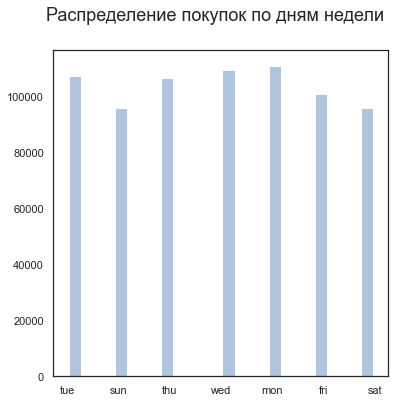

In [139]:
fig, (g1) = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Распределение покупок по дням недели', fontsize=18)

g1.hist(train_new[train_new.rating == 1]['week-day'], bins=20, histtype='bar', align='mid',
        rwidth=0.8, color='lightsteelblue')  # гистограмма
plt.show

Видим, что есть некоторые изменения в количестве покупок (на самом деле в количестве оставленных отзывов!) в зависимости
от дня недели. Небольшое падение активности в субботу и воскресенье, максимальная активность - понедельник, но
колебания не слишком существенные

##### Посмотрим как покупки совершались по временам года

<function matplotlib.pyplot.show(close=None, block=None)>

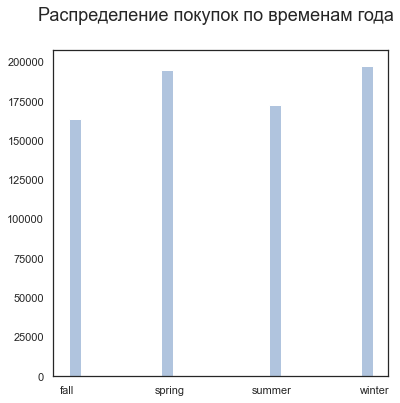

In [140]:
fig, (g1) = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Распределение покупок по временам года', fontsize=18)

g1.hist(train_new[train_new.rating == 1]['season'], bins=20, histtype='bar', align='mid',
        rwidth=0.8, color='lightsteelblue')  # гистограмма
plt.show

Есть небольшие сезонные колебания активности. Наименьшая активность - осенью, максимальная активность зимой и весной.

##### Посмотрим распределение давности оставленных отзывов

<function matplotlib.pyplot.show(close=None, block=None)>

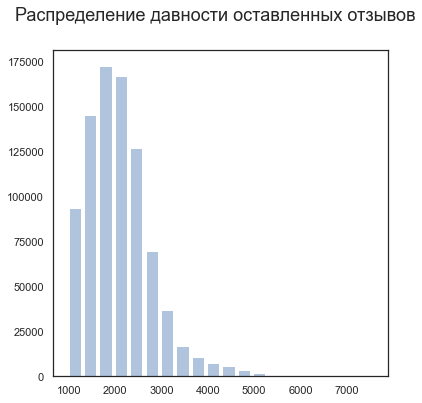

In [164]:
fig, (g1) = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Распределение давности оставленных отзывов', fontsize=18)

g1.hist(train_new['from_today'], bins=20, histtype='bar', align='mid',
        rwidth=0.8, color='lightsteelblue')  # гистограмма
plt.show

Видим, что активность покупателей в последнее время существенно снижается. Она была максимальной 5-6 лет назад
и после этого начала ощутимо уменьшаться. Тенденция к падению интереса сохраняется и руководству магазина нужно бы
обратить на это внимание

##### Посмотрим как влияла оценка субъективности описания товара на покупку

<AxesSubplot:title={'center':'Решения о покупке с объективностью описания'}, xlabel='rating', ylabel='desc_subj'>

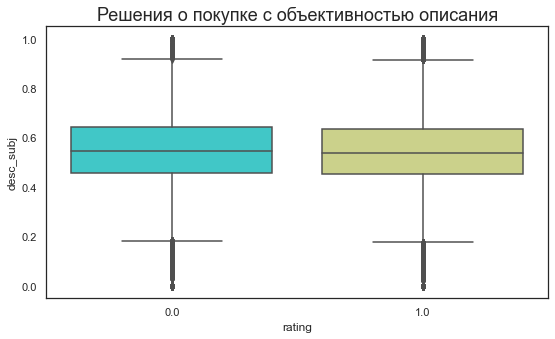

In [141]:
sns.set(style="white")
plt.figure(figsize=(9, 5))
plt.title('Решения о покупке с объективностью описания', fontsize=18)
sns.boxplot(x="rating", y='desc_subj', data=train_new, palette='rainbow')

Видим, что очевидной сильной зависимости между описанием товара и его покупкой (или отказом от покупки) нет, но все равно
оставлю этот признак, так как реальная связь может быть не настолько очевидной

##### Посмотрим как влияло количество людей, проголосовавших за отзыв, на покупку

<AxesSubplot:title={'center':'Решения о покупке с количеством проголосовавших за отзыв'}, xlabel='rating', ylabel='vote'>

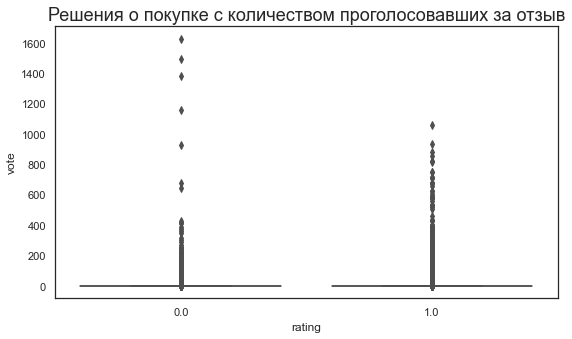

In [142]:
sns.set(style="white")
plt.figure(figsize=(9, 5))
plt.title('Решения о покупке с количеством проголосовавших за отзыв', fontsize=18)
sns.boxplot(x="rating", y='vote', data=train_new, palette='rainbow')

Вот тут очевидно, что люди, совершившие покупку выбирали товар, ориентируясь на количество голосов,
отданых за отзыв о товаре.

##### Посмотрим насколько важной была верифицированность написавшего отзыв покупателя

<function matplotlib.pyplot.show(close=None, block=None)>

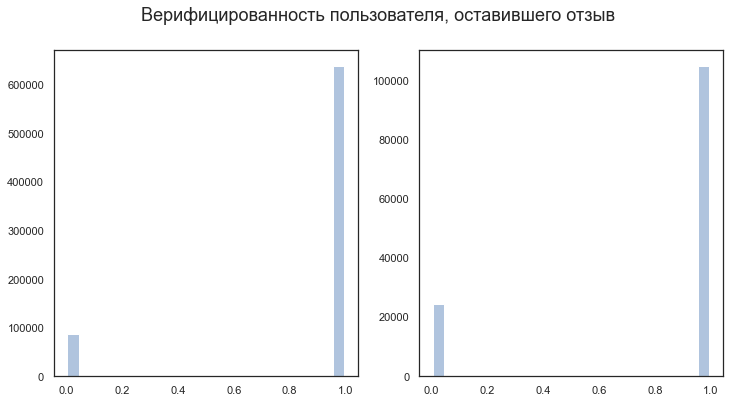

In [146]:
fig, (g1, g2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Верифицированность пользователя, оставившего отзыв', fontsize=18)

# совершили покупку
g1.hist(train_new[train_new.rating == 1]['verified'], bins=20, histtype='bar', align='mid',
        rwidth=0.8, color='lightsteelblue')

# не совершили покупку
g2.hist(train_new[train_new.rating == 0]['verified'], bins=20, histtype='bar', align='mid',
        rwidth=0.8, color='lightsteelblue')
# plt.figtext(0.5, 0, col, fontsize=16)
plt.show

Видим некоторое преобладание неверифицированных отзывов среди отказов от покупки товара

##### Посмотрим в каких основных категориях было совершено больше покупок и было больше отказов от покупки

In [149]:
train_new[train_new.rating == 1].main_cat.value_counts(ascending=False)

Grocery                      688141
Health & Personal Care        29179
Amazon Home                    6182
All Beauty                     1239
Sports & Outdoors               967
Industrial & Scientific         796
Grocery & Gourmet Food          768
Office Products                 542
Toys & Games                    272
Pet Supplies                     95
Tools & Home Improvement         41
Baby                             31
Arts, Crafts & Sewing            16
Home Audio & Theater              8
Camera & Photo                    7
Musical Instruments               3
Cell Phones & Accessories         2
Software                          1
Name: main_cat, dtype: int64

In [150]:
train_new[train_new.rating == 0].main_cat.value_counts(ascending=False)

Grocery                     122415
Health & Personal Care        5158
Amazon Home                   1142
All Beauty                     234
Grocery & Gourmet Food         197
Sports & Outdoors              143
Industrial & Scientific        107
Office Products                100
Toys & Games                    44
Pet Supplies                    32
Baby                            14
Tools & Home Improvement        12
Arts, Crafts & Sewing            3
Software                         2
Home Audio & Theater             1
Camera & Photo                   1
Name: main_cat, dtype: int64

Видим, что "популярность" категорий среди совершенных покупок и отказов примерно одинакова, наибольшее количество "операций"
совершалось в категориях Grocery, Health & Personal Care и Amazon Home

##### Посмотрим влияет ли рейтинг в категории на решение о покупке

<AxesSubplot:title={'center':'Решения о покупке с рейтингом в основной категории'}, xlabel='rating', ylabel='rank_in_main'>

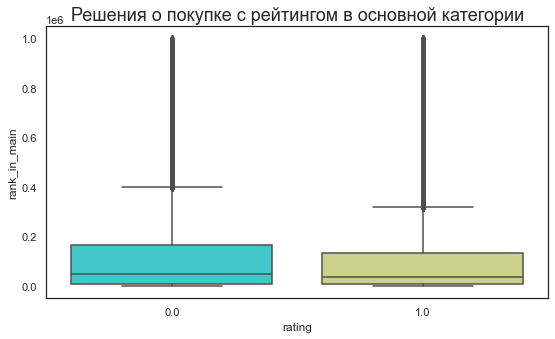

In [151]:
sns.set(style="white")
plt.figure(figsize=(9, 5))
plt.title('Решения о покупке с рейтингом в основной категории', fontsize=18)
sns.boxplot(x="rating", y='rank_in_main', data=train_new, palette='rainbow')

Разница заметна, хоть и не слишком существенна. Самое забавное - среди отказов от покупки
чуть больше товаров с более высоким рейтингом.

##### Посмотрим влияет ли цена на решение о покупке

<AxesSubplot:title={'center':'Решения о покупке с рейтингом в основной категории'}, xlabel='rating', ylabel='price'>

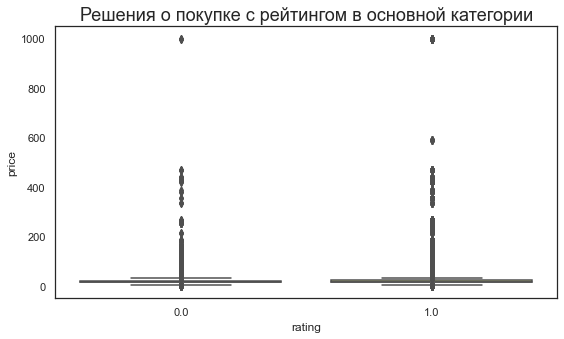

In [152]:
sns.set(style="white")
plt.figure(figsize=(9, 5))
plt.title('Решения о покупке с рейтингом в основной категории', fontsize=18)
sns.boxplot(x="rating", y='price', data=train_new, palette='rainbow')

Показатели примерно одинаковы

##### Посмотрим влияет ли цена на рейтинг товара

<AxesSubplot:title={'center':'Зависимость между ценой и рейтингом в основной категории (цена до 100)'}, xlabel='price', ylabel='rank_in_main'>

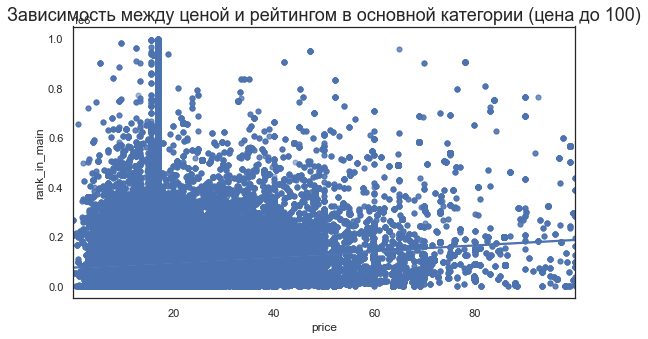

In [169]:
sns.set(style="white")
plt.figure(figsize=(9, 5))
plt.title('Зависимость между ценой и рейтингом в основной категории (цена до 100)', fontsize=18)
# ограничиваем диапазоп значений предиктора для улучшения визуализации (если нужно)
data1 = train_new[train_new['price'] < 100]
sns.regplot('price', "rank_in_main", data=data1,
            scatter_kws={'s': 25, "alpha": 0.5})

График показывает, что существенного влияния цена на рейтинг товара в его основной категории не оказывает.
Данные распределены достаточно плотно и равномерно, хотя и наблюдается некоторое снижение рейтинга при увеличении цены.

### Нормализация данных

In [155]:
scaler = preprocessing.StandardScaler()

In [158]:
# отберем признаки для нормализации (оценку субъективности отзыва не буду нормализовать - она по определению
# в пределах от 0 до 1
train_for_scaler = train_new[['from_today',
                              'vote', 'numb_of_cat', 'rank_in_main', 'price']]

In [159]:
train_for_scaler = scaler.fit_transform(train_for_scaler)

In [162]:
train_scaled = pd.DataFrame(train_for_scaler, columns=[
                            'from_today', 'vote', 'numb_of_cat', 'rank_in_main', 'price'])

In [163]:
train_scaled

,from_today,vote,numb_of_cat,rank_in_main,price
0,0.109837,0.00000,0.222222,0.019794,0.009950
1,0.142577,0.00000,0.222222,0.005598,0.018499
2,0.124925,0.01722,0.222222,0.000000,0.016997
3,0.279572,0.00000,0.222222,0.169115,0.044985
4,0.112855,0.00000,0.222222,0.061762,0.016997
...,...,...,...,...,...
857890,0.303108,0.00000,0.111111,0.026339,0.022182
857891,0.154496,0.00000,0.333333,0.720370,0.016997
857892,0.111798,0.00000,0.222222,0.014631,0.022463
857893,0.160833,0.00000,0.222222,0.000018,0.013674


Присоединим к этим нормализованным данным **userid**, **itemid**, **rating**, **verified**, **desc_subj** и преобразованные
в dummies данные о днях недели, сезонах и основных категориях

Для начала получим dummies

In [172]:
train_dummies = pd.get_dummies(train_new[['week-day', 'season', 'main_cat']])

In [173]:
train_dummies

,week-day_fri,week-day_mon,week-day_sat,week-day_sun,week-day_thu,week-day_tue,week-day_wed,season_fall,season_spring,season_summer,...,main_cat_Health & Personal Care,main_cat_Home Audio & Theater,main_cat_Industrial & Scientific,main_cat_Musical Instruments,main_cat_Office Products,main_cat_Pet Supplies,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Tools & Home Improvement,main_cat_Toys & Games
0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
857891,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
857892,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
857893,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, собираем базу, с которой будем обучать модель.

In [174]:
train_for_model = pd.concat([train_new[['rating', 'userid', 'itemid',
                                        'verified', 'desc_subj']], train_scaled, train_dummies], axis=1)

In [176]:
train_for_model.to_csv('train_for_model.csv')

In [181]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   verified      285965 non-null  object        
 1   reviewTime    285965 non-null  datetime64[ns]
 2   from_today    285965 non-null  int64         
 3   week-day      285965 non-null  object        
 4   season        285965 non-null  object        
 5   asin          285965 non-null  object        
 6   vote          285965 non-null  int64         
 7   categories    285965 non-null  object        
 8   numb_of_cat   285965 non-null  float64       
 9   main_cat      285965 non-null  object        
 10  rank_in_main  285965 non-null  float64       
 11  price         285965 non-null  float64       
 12  desc_subj     285965 non-null  float64       
 13  userid        285965 non-null  int64         
 14  itemid        285965 non-null  int64         
 15  train/test    285

In [182]:
test_new.to_csv('test_new.csv')

Полученные и сохраненные базы будем использовать в новом ноутбуке для обучения и работы модели.

Для последующего использования в рекомендательной системе мне нужно создать базу, в которой каждому itemid
будет соответствовать название товара.

Сначала выделим все itemid и свяжем их с asin


In [199]:
df_item_asin = df.groupby('itemid').asin.value_counts()

In [211]:
len(df_item_asin)

41320

In [210]:
df_item_asin.loc[41315].index[0]

'B01H8ET97A'

In [212]:
item_list = list(df.itemid.unique())
print(len(item_list))

41320 5430


In [214]:
# Сделаю табличку в которой будет itemid, asin, title
titles = pd.DataFrame(np.nan, index=[0, len(item_list)], columns=[
                      'itemid', 'asin', 'title'])

In [ ]:
# "Выташим" названия товара в словарь - asin = title
titiles_dict = {}
for i in tqdm(range(len(data))):
    titiles_dict[data.asin.iloc[i]]=data.title.iloc[i]

# а теперь заполним, наконец таблицу
for i in tqdm(range(len(titles))):
    item_list[i] = item
    titles.itemid.iloc[i] = item
    titles.asin.iloc[i] = df_item_asin.loc[item].index[0]
    titles.title.iloc[i] = titiles_dict[df_item_asin.loc[item].index[0]]
# Сохраним табличку для последующего использования
titles.to_csv('titles.csv')
    

Все ранее сохраненные данные будем использовать в следующих ноутбуках для обучения модели, получения и
интерпретации предсказаний.